In [28]:
import pandas as pd
import numpy as np
import shap
import warnings
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings("ignore")
village_data = pd.read_csv(r'C:\Users\12045\Desktop\村数据(预处理后).csv')
X = village_data.drop(columns=['liuzhuandiarea'])
y = village_data['liuzhuandiarea']

In [29]:
# 方差选择法 
threshold = 0.5
selector_variance = VarianceThreshold(threshold=threshold)
X_selected_variance = selector_variance.fit_transform(X)
selected_features_variance = X.columns[selector_variance.get_support()]

# L1正则法
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
# 获取系数非零的特征
selected_features_lasso = X.columns[lasso.coef_ != 0]

# 互信息
from sklearn.feature_selection import mutual_info_regression
# 计算特征与目标变量的互信息
mi_scores = mutual_info_regression(X, y)
# 选择互信息得分较高的特征
selected_features_mi = X.columns[np.argsort(mi_scores)[-5:]]

# 随机森林
model_tree = RandomForestRegressor()
model_tree.fit(X, y)
# 获取特征重要性
feature_importances = model_tree.feature_importances_
# 选择重要性较高的特征
threshold_tree = 0.01  # 假设选择重要性大于0.01的特征
selected_features_tree = X.columns[feature_importances > threshold_tree]

# 相关系数法
# 这里以绝对值相关系数大于阈值作为特征选择标准
threshold_correlation = 0.5  # 设定阈值
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
selected_features_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold_correlation)]

# 将所有特征子集整合到一个集合中
all_feature_sets = []
all_feature_sets.extend(selected_features_variance)
all_feature_sets.extend(selected_features_tree)
all_feature_sets.extend(selected_features_lasso)
all_feature_sets.extend(selected_features_correlation)
all_feature_sets.extend(selected_features_mi)

# 计算每个特征子集的重叠次数
overlap_counts = {}
for feature_set in all_feature_sets:
    if feature_set in overlap_counts:
        overlap_counts[feature_set] += 1
    else:
        overlap_counts[feature_set] = 1

# 找到重叠次数大于等于2的特征子集
min_overlap_count = 2
selected_feature_sets = [feature_set for feature_set, count in overlap_counts.items() if count >= min_overlap_count]

print("重叠次数大于等于2的特征子集:")
for feature_set in selected_feature_sets:
    print(feature_set)
print("重叠次数:", min_overlap_count)


重叠次数大于等于2的特征子集:
zhandiarea
gengdiarea
quequanyear
quequanarea
jidongdiarea
chengbaodiarea
liangshiarea
nonghujyarea
qiyejyarea
hezuoshejyarea
qitajyarea
zhuti500
zhuti200
zhuti100
zhuti50
zhutiwaicun
xinzenggdarea
gjjsarea
xjfwarea
tuigengarea
zhuanbaonum
jizhongzcarea
jizhongzcareacgb
jizhongzcareanh
jizhongzcqiyearea
jizhongzchezuoshearea
jizhongzcnonghuarea
jizhongzcwaicunarea
vid
重叠次数: 2


In [30]:
# 划分训练集和测试集
# 选取目标列和特征列，划分数据集,去除会得出无效结论特征，如承包地面积
excluded_features = ['zhandiarea', 'gengdiarea', 'quequanyear', 'quequanarea', 'jidongdiarea',
                     'chengbaodiarea', 'liangshiarea', 'vid','qiyejyarea','hezuoshejyarea',
                     'xinzenggdarea','gjjsarea','zhutiwaicun','nonghujyarea']
X = village_data[selected_feature_sets].drop(columns=excluded_features, errors='ignore')
# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 线性回归

# 初始化线性回归模型
model = LinearRegression()
# 在训练集上训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 计算各项指标
print('\n线性回归模型各项指标:')
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)



线性回归模型各项指标:
均方误差（MSE）: 1.7255607849575425
平均绝对误差（MAE）: 0.7533155178234554
R-squared: -0.691052574253235


In [26]:
# 随机森林
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# 定义目标函数
def evaluate_rf(n_estimators, max_depth, min_samples_split):
    # 创建随机森林模型
    rf_model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )
    # 进行交叉验证
    scores = -cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # 返回负均方误差的均值（贝叶斯优化最小化目标）
    return scores.mean()
# 定义超参数搜索空间
pbounds = {'n_estimators': (50, 100),
           'max_depth': (5, 10),
           'min_samples_split': (5, 10)}
# 初始化贝叶斯优化搜索
bayesian_opt = BayesianOptimization(
    f=evaluate_rf,
    pbounds=pbounds,
    random_state=42
)
# 开始贝叶斯优化搜索
print("正在使用贝叶斯优化搜索最佳参数...")
bayesian_opt.maximize(init_points=10, n_iter=50)
# 输出最佳参数
best_params = bayesian_opt.max
print("最佳参数:", best_params)
# 使用最佳参数的模型进行预测
best_rf_model = RandomForestRegressor(
    n_estimators=int(best_params['params']['n_estimators']),
    max_depth=int(best_params['params']['max_depth']),
    min_samples_split=int(best_params['params']['min_samples_split']),
    random_state=42
)
best_rf_model.fit(X_train, y_train)  # 拟合训练集
y_pred = best_rf_model.predict(X_test)
print("\n随机森林模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')


正在使用贝叶斯优化搜索最佳参数...
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 1.039     | 6.873     | 9.754     | 86.6      |
| 2         | 1.02      | 7.993     | 5.78      | 57.8      |
| 3         | 1.024     | 5.29      | 9.331     | 80.06     |
| 4         | 1.072     | 8.54      | 5.103     | 98.5      |
| 5         | 1.019     | 9.162     | 6.062     | 59.09     |
| 6         | 1.036     | 5.917     | 6.521     | 76.24     |
| 7         | 1.046     | 7.16      | 6.456     | 80.59     |
| 8         | 1.022     | 5.697     | 6.461     | 68.32     |
| 9         | 1.004     | 7.28      | 8.926     | 59.98     |
| 10        | 1.022     | 7.571     | 7.962     | 52.32     |
| 11        | 1.067     | 10.0      | 5.0       | 93.3      |
| 12        | 1.045     | 10.0      | 10.0      | 100.0     |
| 13        | 1.052     | 5.0       | 5.0       | 95.51     |
| 14        | 1.054     | 10.0      | 5.0       | 8

In [6]:
# XGBoost(极限梯度提升)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 8]
}

# 初始化XGBoost回归模型
xgb_regressor = xgb.XGBRegressor()

# 使用网格搜索进行参数调优
print("正在使用网格搜索寻找模型最佳参数...")
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和对应的性能指标
print("最佳参数:", grid_search.best_params_)

# 获取经过参数调优后的最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
y_pred = best_model.predict(X_test)

print("\nXGBoost模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')

正在使用网格搜索寻找模型最佳参数...
最佳参数: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}

XGBoost模型各项误差指标
均方误差（MSE）: 0.7244408748064469
平均绝对误差（MAE）: 0.6671967461015468
R-squared: 0.29004668110497744 



In [7]:
# SVM支持向量机

svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)


print("\nSVM模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')


SVM模型各项误差指标
均方误差（MSE）: 0.7244408748064469
平均绝对误差（MAE）: 0.6671967461015468
R-squared: 0.29004668110497744 



In [8]:
# 决策树

tree_model = DecisionTreeRegressor(random_state=43)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print("\n决策树模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')


决策树模型各项误差指标
均方误差（MSE）: 0.9130265867892347
平均绝对误差（MAE）: 0.7499806233786316
R-squared: 0.10523235494739791 



使用随机森林

In [36]:
# 随机森林

# 初始化随机森林模型
rf_model = RandomForestRegressor(random_state=42)

# 定义超参数搜索空间(模型将自动选取最好的那一组参数值)
# 解释：网格搜索是暴力搜索，在给定超参搜索空间内，尝试所有超参组合，最后搜索出最优的超参组合。
param_grid = {
    'n_estimators': [50, 100, 200,1000],  # 树的数量
    'max_depth': [10, 20, 30, 50],  # 树的最大深度
    'min_samples_split': [2, 3, 5, 7, 10, 15]  # 最小分裂样本数
}

# 初始化网格搜索
print("正在使用网格搜索寻找模型最佳参数...")
# estimator:优化的模型  param_grid:超参数空间   cv:交叉验证的折数  scoring:评估指标（此处用的是负均方误差）  verbose: 设为1表示输出进度
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# 在训练集上进行网格搜索 对每一种超参数组合进行交叉验证，并选择在验证集上性能最好的模型
grid_search.fit(X_train, y_train)

# 输出最佳参数
best_params = grid_search.best_params_
print("最佳参数:", best_params)

# 使用最佳参数的模型进行预测
best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

print("\n随机森林模型各项误差指标")
mse = mean_squared_error(y_test, y_pred)
print("均方误差（MSE）:", mse)
mae = mean_absolute_error(y_test, y_pred)
print("平均绝对误差（MAE）:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2, '\n')

# 计算各特征SHAP值(随机森林模型训练和预测中间)
# 创建 TreeExplainer 解释器（用于树模型）
explainer = shap.TreeExplainer(best_rf_model)
# 计算 SHAP 值
shap_values = explainer.shap_values(X)

# 计算特征重要性
shap_importance = np.abs(shap_values).mean(0)
shap_importance_df = pd.DataFrame(shap_importance, index=X_train.columns, columns=["SHAP Importance"])
shap_importance_df = shap_importance_df.sort_values(by="SHAP Importance", ascending=False)
print("\n各特征SHAP值(随机森林模型):\n", shap_importance_df)

正在使用网格搜索寻找模型最佳参数...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
最佳参数: {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 50}

随机森林模型各项误差指标
均方误差（MSE）: 0.636580378996876
平均绝对误差（MAE）: 0.6077805441575872
R-squared: 0.3761501200038837 


各特征SHAP值(随机森林模型):
                        SHAP Importance
zhuti200                      0.231937
zhuti100                      0.173379
zhuti500                      0.137180
zhuti50                       0.047065
zhuanbaonum                   0.042177
xjfwarea                      0.039164
jizhongzcareacgb              0.033893
qitajyarea                    0.028968
jizhongzcareanh               0.016272
jizhongzcarea                 0.013243
jizhongzcnonghuarea           0.011094
jizhongzchezuoshearea         0.007041
jizhongzcqiyearea             0.005802
tuigengarea                   0.003586
jizhongzcwaicunarea           0.003306


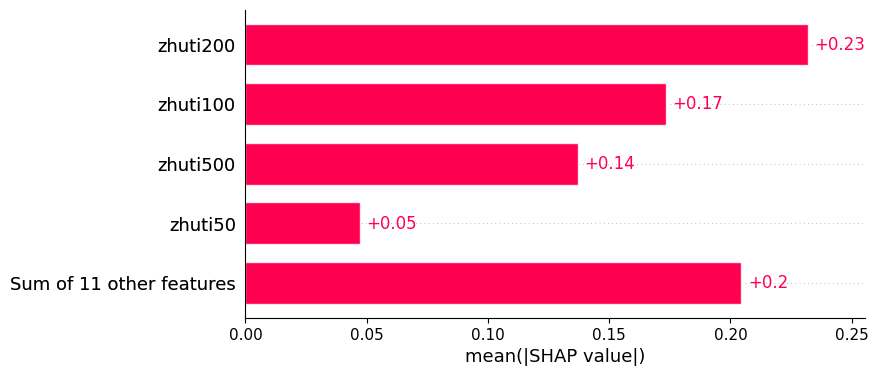

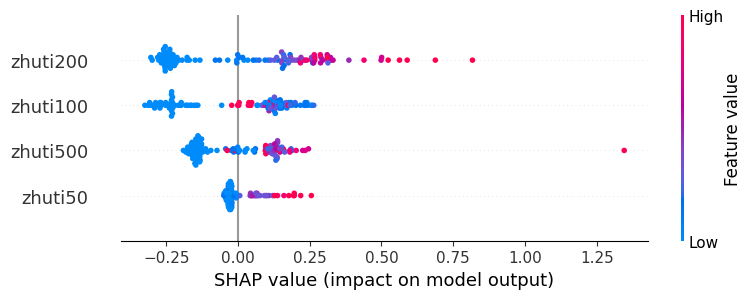

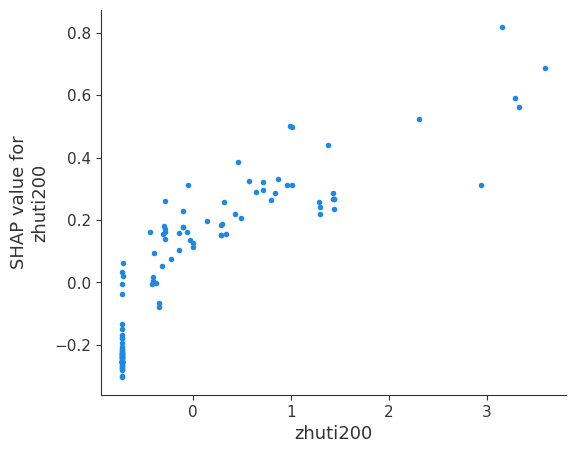

In [37]:
# 可视化 SHAP 值
# 柱状图
shap.plots.bar(shap_values2, max_display=5)

# 散点分布图
shap.summary_plot(shap_values, X, max_display=4)

# SHAP值最大的特征的shap值演变
shap.dependence_plot('zhuti200', shap_values, X, interaction_index=None)
